## The data figure we want to reproduce (from [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3039263/figure/fig01/))

![data-figure](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3039263/bin/tjp0589-0101-f1.jpg)

In [1]:
%matplotlib inline

# Built-in libs
import os
import sys
import warnings

# Common libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq

# Open Worm libs
import owtests
import c302

# Testing libs
warnings.simplefilter('ignore')
import sciunit
from neuronunit.tests import waveform,dynamics
import quantities as pq
from c302.muscleunit import vm_plot,models as sciunit_models

In [2]:
# Create a MuscleModel instance with a particular configuration
# This model has a neuron and a muscle cell
config = 'IClampBWM'
parameter_set = 'C2'
duration = 1000 # ms
dt = 0.05 # ms
model = sciunit_models.MuscleModel(config, parameter_set, duration, dt, config_package="notebooks.configs")

Set default parameters for C
Set default parameters for C2
Opened file: /Users/rick/Dropbox (ASU)/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/../../../herm_full_edgelist.csv
Opened file: /Users/rick/Dropbox (ASU)/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/../../../herm_full_edgelist.csv
c302      >>>  Positioning muscle: MDR01 at (80,-270,80)
c302      >>>  Writing generated network to: /Users/rick/Dropbox (ASU)/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/examples/c302_C2_IClampBWM.nml
(Re)written network file to: /Users/rick/Dropbox (ASU)/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/examples/c302_C2_IClampBWM.nml


## Action potential waveform shape tests

In [3]:
# Dictionary of observations, in this case two ephys properties from one paper


doi = 'doi:10.1113/jphysiol.2010.200683' # The DOI of the paper
# Observations copied from the table in the paper
observations={doi:{'ap_amplitude':{'mean':45.1*pq.mV,
                                   'sem':0.7*pq.mV,
                                   'n':25},
                   'ap_width':{'mean':19.7*pq.ms,
                               'sem':1.0*pq.ms,
                               'n':25}}}    

# Instantiate two tests based on these properties
ap_width_test = waveform.APWidthTest(observation=observations[doi]['ap_width'])
ap_amplitude_test = waveform.APAmplitudeTest(observation=observations[doi]['ap_amplitude'])

## Interspike interval distribution tests

In [4]:
# Load a digitized version of an ISI histogram
df = pd.read_csv('data/digitized_histogram.csv',header=None,names=['Bin Centers','Counts'],index_col=0)
df = df.astype('int') # Set ISI counts to integers
df.index = df.index.values.round(3) # Round the bin centers to the nearest ms
df.head()

,Counts
0.096,4
0.209,207
0.317,278
0.410,238
0.512,177


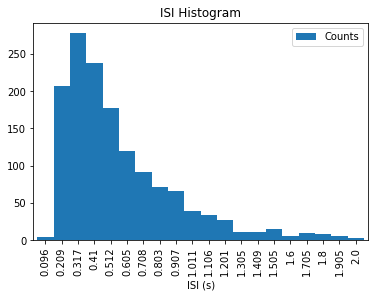

In [5]:
width = df.index.values[1] - df.index.values[0] # Bin width from the original histogram
df.plot.bar(align='center',width=1)
plt.title('ISI Histogram');
plt.xlabel('ISI (s)');

In [6]:
# Make surrogate data for a MLE fit
surrogate_data = []
for bin_center in df.index:
    count = int(df.loc[bin_center])
    surrogate_data += [bin_center]*count

Gamma parameters:
	Shape: 2.2
	Scale: 0.22
	Loc: 0.091
Statistics:
	Mean: 0.56
	Standard Deviation 0.32


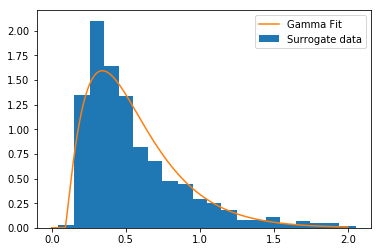

In [7]:
# Do the fit on the surrogate data to get the estmated parameters
from scipy.stats import gamma
isi_shape,isi_loc,isi_scale = gamma.fit(surrogate_data)
isi_mean, isi_var, isi_skew, isi_kurt = gamma.stats(isi_shape,loc=isi_loc,scale=isi_scale, moments='mvsk')
isi_std = np.sqrt(isi_var)
isi_cv = isi_std/isi_mean
bins = list(df.index - width/2) # Get the left edges of the bins
bins += [bins[-1]+width] # Add the right edge of the last bin
plt.hist(surrogate_data,bins=bins,normed=True,label='Surrogate data')
xs = np.linspace(0,df.index.max(),1000)
plt.plot(xs,gamma.pdf(xs,isi_shape,loc=isi_loc,scale=isi_scale),label='Gamma Fit')
plt.legend()
print('Gamma parameters:\n\tShape: {:.2g}\n\tScale: {:.2g}\n\tLoc: {:.2g}'.format(isi_shape,isi_scale,isi_loc))
print('Statistics:\n\tMean: {:.2g}\n\tStandard Deviation {:.2g}'.format(isi_mean,isi_std))

In [8]:
# ISI Mean Test
observation = {doi:
                {'mean':isi_mean*pq.s,
                 'std':isi_std*pq.s,
                 'cv':isi_cv}}
isi_test = dynamics.ISITest(observation=observation[doi])
cv_test = dynamics.ISICVTest(observation=observation[doi])

In [9]:
# Put them all together in a test suite
ap_tests = sciunit.TestSuite([ap_width_test,ap_amplitude_test,isi_test,cv_test], name="AP ISI and CV Tests")

In [10]:
# Judge the membrane potential of the muscle 
# One could judge the neuron instead with appropriate keyword parameters, see below)
%time score_matrix = ap_tests.judge(model) 
import pandas as pd
score_matrix.style.set_properties(**{'font-size':'16pt'})
score_matrix

pyNeuroML >>> Reloading data specified in LEMS file: /var/folders/38/fjx1_pkn3jq0xf9nf5pd7f180000gp/T/tmpvnlwekzv/LEMS_c302_C2_IClampBWM.xml (/private/var/folders/38/fjx1_pkn3jq0xf9nf5pd7f180000gp/T/tmpvnlwekzv/LEMS_c302_C2_IClampBWM.xml), base_dir: /var/folders/38/fjx1_pkn3jq0xf9nf5pd7f180000gp/T/tmpqfb8917v, cwd: /Users/rick/Dropbox (ASU)/dev/openworm/tests/owtests/CElegansNeuroML


{'cv': 0.5702021744285034, 'std': array(0.31848194) * s, 'mean': array(0.55854213) * s} {'cv': array(0.49462015) * dimensionless}


CPU times: user 774 ms, sys: 35.9 ms, total: 809 ms
Wall time: 5.25 s


/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  self.parser.feed(markup)


,APWidthTest,APAmplitudeTest,ISITest,ISICVTest
LEMS_c302_C2_IClampBWM,Z = -3.06,Z = -11.03,Z = -0.90,Ratio = 0.87


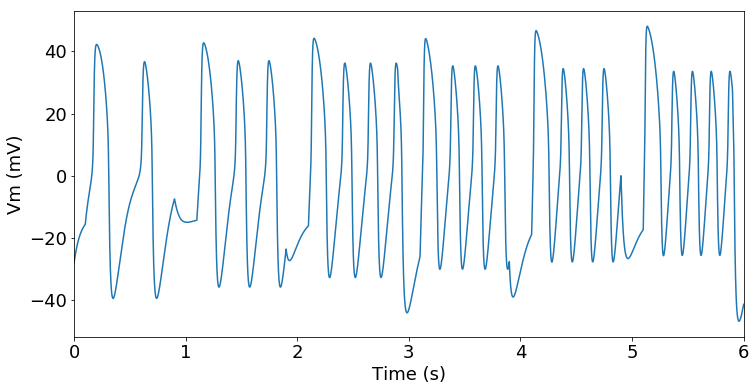

In [11]:
# Plot the model output for one of the tests
plt.rcParams.update({'font.size':18,'figure.figsize':(12,6)})
score_matrix['APWidthTest']['LEMS_c302_C2_IClampBWM'].plot_vm()
plt.savefig('model.pdf')

## Model methods could also be run directly as follows

In [12]:
# These will use the cached results and so be much faster than the original run
%time neuron_vm = model.get_membrane_potential_neuron()
%time muscle_vm = model.get_membrane_potential_muscle()

CPU times: user 10.5 ms, sys: 1.62 ms, total: 12.1 ms
Wall time: 13.5 ms
CPU times: user 11 ms, sys: 1.4 ms, total: 12.4 ms
Wall time: 13.4 ms


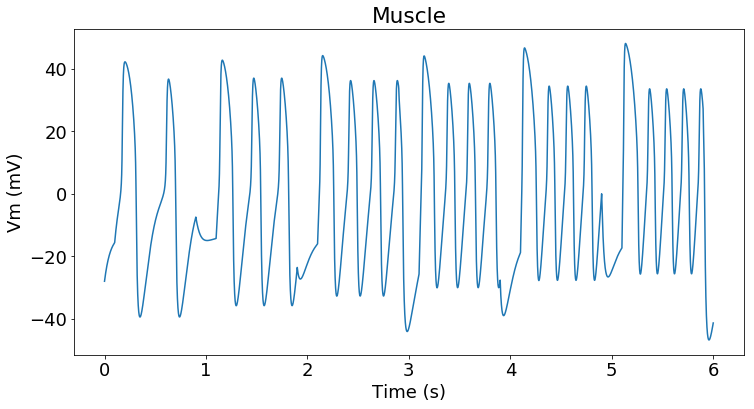

In [13]:
# Another way to plot the model output, in this case by cell type
vm_plot(muscle_vm,"Muscle")

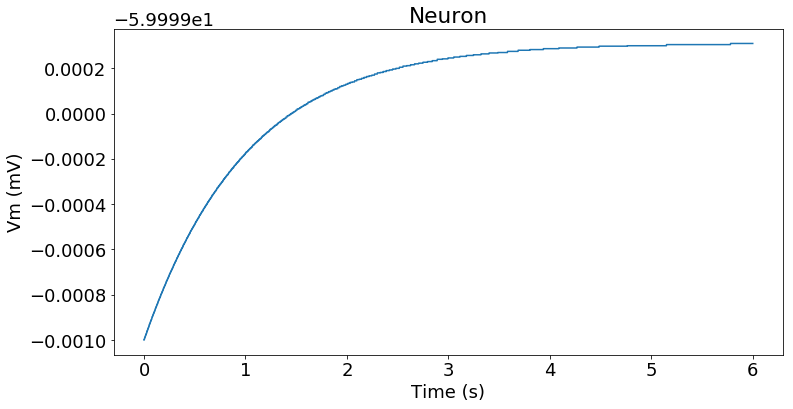

In [14]:
# Same as above, but for a different cell type in this model
# Note that in this flavor of the model, the neuron isn't doing anything at all, 
# and the muscle cell is firing spontaneously
vm_plot(neuron_vm,"Neuron")